<center><h1> data-splitting test : post-solar vs post-lasso </h1></center>

## In this file, we show the detailed step and resut of post-solar and post-lasso data-splitting test.

---

## Check the following before running the code

### (a) Read "README.pdf" in this folder first, which introduces the package

### (b) Before replication, delete all .p files in the "./numerical_result" folder. The .p files record the numerical results of the our computation.

### (c) To avoid confusion, reset your kernel before you running the notebook (to clear memory): 
* <font size="4.5"> In Jupyter Notebook/Lab : go to Menu "Kernel" $\rightarrow$ "Restart Kernel and clear all outputs". </font> 

### (d) To evaluate the code for simulation replication in Jupyter Notebook/Lab,
* <font size="4.5"> click : Menu "Kernel" $\rightarrow$ "Restart Kernel and Run All Cells" </font>
* <font size="4.5"> or, select a cell of code, press "shift" and "enter". Run all cells to avoid errors </font>

### (e) Check "joblib", "scikit-learn", "numpy", "matplotlib" and "tqdm" are installed. If not,
* <font size="4.5"> we highly recommend installing Anaconda3 version 2020-11 directly to avoid package management (all packages mentioned above are installed by default).</font>

---

## #1: import all modules

* <font size="4.5"> "pickle" is used to save all computation results into ".p" files, which can be loaded later. </font>

* <font size="4.5"> For simplicity and elegancy, all relevant functions and classes are coded in "simul_plot_ic.py". </font>

In [1]:
%reset -f

import itertools
import time
import pickle

import numpy             as np
import pandas            as pd
import seaborn           as sns
import statsmodels.api   as sm
import matplotlib.pyplot as plt


from sklearn              import linear_model
from sklearn.metrics      import mean_squared_error
from tqdm                 import tqdm_notebook
from tqdm.notebook        import trange
from tqdm                 import tqdm
from solar                import solar
from sklearn.linear_model import LassoCV

## make sure we use the Intel MKL C++/Fortran compiler for maximum performance.

In [2]:
import mkl

mkl.get_version_string()

'Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications'

In [3]:
print('This was obtained using the following Numpy configuration:')

np.show_config()

This was obtained using the following Numpy configuration:
blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/ning/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ning/anaconda3/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/ning/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ning/anaconda3/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/ning/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ning/anaconda3/include']
lapack_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/ning/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ning/anaconda3/include']
Supported SIMD extensions in this NumPy install:
    

# fix random seeds

In [4]:
np.random.seed(0)

# define data generator for simulation (copied from "simulator.py")

In [5]:
def data_gen(sample_size, n_dim, n_info):  
  
    ############ generate data #################
    ##1. generating the covariance matrix for X,
    #we add a matrix full of 1/2 with an identity matrix multiplied with 1/2
    a     = np.ones((n_dim, n_dim)) * 0.5
    A     = np.eye(n_dim)*0.5
    cov_x = a + A
    ##2. generating the mean of each column in X (which is 0)
    mean_x = np.zeros(n_dim)
    ##3. generating X as a multivariate Gaussian
    X_org = np.random.multivariate_normal(mean_x, cov_x, sample_size)
    ##4. generate regression coefficients in DGP as an increasing sequence (2,3,4,5,6 in our paper)
    beta_info = np.arange(1, n_info+1)
    #in DGP, generate regression coefficients of redundant variables as 0
    #concatenate the regression coefficients of informative variables and redundant variables
    beta = np.concatenate((beta_info, np.zeros(n_dim - n_info)), axis = 0)
    ##5. generate the Gaussian random noise
    noise = np.random.normal(0, 1, sample_size)
    #transform Gaussian random noise into a column
    #transform regression coefficients in DGP into a row (based on the requirement of np.inner )
    noise.shape = (sample_size, 1); beta.shape = (1, n_dim)
    ##6. generate Y by adding random noise with the inner product of X and beta
    Y_org = np.inner(X_org,beta) + noise

    return X_org, Y_org

# Now let's automate everything above for 100 repetitions

In [6]:
np.random.seed(0)

n_dim = 140
sample_size = 120

In [7]:
def simul_func():
  
    ############ lists #################

    X0_t = list()
    X1_t = list()
    X2_t = list()
    X3_t = list()
    X4_t = list()
    X5_t = list()
    X6_t = list()
    X0_p = list()
    X1_p = list()
    X2_p = list()
    X3_p = list()
    X4_p = list()
    X5_p = list()
    X6_p = list()

    X0_t_lasso = list()
    X1_t_lasso = list()
    X2_t_lasso = list()
    X3_t_lasso = list()
    X4_t_lasso = list()
    X5_t_lasso = list()
    X6_t_lasso = list()
    X0_p_lasso = list()
    X1_p_lasso = list()
    X2_p_lasso = list()
    X3_p_lasso = list()
    X4_p_lasso = list()
    X5_p_lasso = list()
    X6_p_lasso = list()

    for i in tqdm(range(0,100)):

        X_org, Y_org = data_gen(sample_size, n_dim, 5)
        
        ###### post-solar hold-out average ###########
        
        X_half_1 = X_org[0:int(sample_size/2),:]
        Y_half_1 = Y_org[0:int(sample_size/2),:]
        X_half_2 = X_org[int(sample_size/2):sample_size,:]
        Y_half_2 = Y_org[int(sample_size/2):sample_size,:]

        trial2_h1 = solar(X_half_1, Y_half_1, 10, -0.01, lasso=False)
        trial2_h2 = solar(X_half_2, Y_half_2, 10, -0.01, lasso=False)

        _, _, _, _, Q_opt_c_h1, _, _, _, _ = trial2_h1.fit()
        _, _, _, _, Q_opt_c_h2, _, _, _, _ = trial2_h2.fit()

        Q_opt_c = np.unique(np.concatenate((Q_opt_c_h1, Q_opt_c_h2, np.arange(0,7)),axis=0))

        # train lasso
        YY_half_1 = Y_half_1; YY_half_1.shape = (Y_half_1.shape[0],)

        trial3_h1 = LassoCV(cv=10, random_state=0)

        trial3_h1.fit(X_half_1, YY_half_1)

        lasso_active_h1 = np.nonzero(trial3_h1.coef_)[0]

        YY_half_2 = Y_half_2; YY_half_2.shape = (Y_half_2.shape[0],)

        trial3_h2 = LassoCV(cv=10, random_state=0)

        trial3_h2.fit(X_half_2, YY_half_2)

        lasso_active_h2 = np.nonzero(trial3_h2.coef_)[0]

        joint_lasso = np.unique(np.concatenate((lasso_active_h1, lasso_active_h2, np.arange(0,7)),axis=0))

        #### 2 halves of the hold-out ####
        solar_active_var = ['X' + str(i) for i in Q_opt_c]
        
        var_name = ['X' + str(i) for i in np.arange(0,n_dim)]
        
        X_half_1 = pd.DataFrame(X_half_1, columns=var_name)
        Y_half_1 = pd.DataFrame(Y_half_1, columns=['Y'])
        X_half_2 = pd.DataFrame(X_half_2, columns=var_name)
        Y_half_2 = pd.DataFrame(Y_half_2, columns=['Y'])

        #first half OLS
        solar_active_var = ['X' + str(i) for i in Q_opt_c]
        XX_half_1 = X_half_1[solar_active_var]
        YY_half_1 = Y_half_1
        XX_half_1 = sm.add_constant(XX_half_1)
        reg_half_1 = sm.OLS(YY_half_1, XX_half_1)

        result_half_1 = reg_half_1.fit()

        #2nd half

        XX_half_2 = X_half_2[solar_active_var]
        YY_half_2 = Y_half_2
        XX_half_2 = sm.add_constant(XX_half_2)
        reg_half_2 = sm.OLS(YY_half_2, XX_half_2)

        result_half_2 = reg_half_2.fit()

        #post-lasso 1st half

        lasso_active_var = ['X' + str(i) for i in joint_lasso]
        XX_half_1 = X_half_1[lasso_active_var]
        YY_half_1 = Y_half_1
        XX_half_1 = sm.add_constant(XX_half_1)
        reg_lasso_1 = sm.OLS(YY_half_1, XX_half_1)

        result_lasso_1 = reg_lasso_1.fit()

        #post-lasso 2nd half

        XX_half_2 = X_half_2[lasso_active_var]
        YY_half_2 = Y_half_2
        XX_half_2 = sm.add_constant(XX_half_2)
        reg_lasso_2 = sm.OLS(YY_half_2, XX_half_2)

        result_lasso_2 = reg_lasso_2.fit()

        #hold-out average
        X0_t.append((result_half_1.tvalues[1] + result_half_2.tvalues[1])/2)
        X1_t.append((result_half_1.tvalues[2] + result_half_2.tvalues[2])/2)
        X2_t.append((result_half_1.tvalues[3] + result_half_2.tvalues[3])/2)
        X3_t.append((result_half_1.tvalues[4] + result_half_2.tvalues[4])/2)
        X4_t.append((result_half_1.tvalues[5] + result_half_2.tvalues[5])/2)
        X5_t.append((result_half_1.tvalues[6] + result_half_2.tvalues[6])/2)
        X6_t.append((result_half_1.tvalues[7] + result_half_2.tvalues[7])/2)
        
        X0_t_lasso.append((result_lasso_1.tvalues[1] + result_lasso_2.tvalues[1])/2)
        X1_t_lasso.append((result_lasso_1.tvalues[2] + result_lasso_2.tvalues[2])/2)
        X2_t_lasso.append((result_lasso_1.tvalues[3] + result_lasso_2.tvalues[3])/2)
        X3_t_lasso.append((result_lasso_1.tvalues[4] + result_lasso_2.tvalues[4])/2)
        X4_t_lasso.append((result_lasso_1.tvalues[5] + result_lasso_2.tvalues[5])/2)
        X5_t_lasso.append((result_lasso_1.tvalues[6] + result_lasso_2.tvalues[6])/2)
        X6_t_lasso.append((result_lasso_1.tvalues[7] + result_lasso_2.tvalues[7])/2)
        
        #extract p values#
        X0_p.append((result_half_1.pvalues[1] + result_half_2.pvalues[1])/2)
        X1_p.append((result_half_1.pvalues[2] + result_half_2.pvalues[2])/2)
        X2_p.append((result_half_1.pvalues[3] + result_half_2.pvalues[3])/2)
        X3_p.append((result_half_1.pvalues[4] + result_half_2.pvalues[4])/2)
        X4_p.append((result_half_1.pvalues[5] + result_half_2.pvalues[5])/2)
        X5_p.append((result_half_1.pvalues[6] + result_half_2.pvalues[6])/2)
        X6_p.append((result_half_1.pvalues[7] + result_half_2.pvalues[7])/2)

        X0_p_lasso.append((result_lasso_1.pvalues[1] + result_lasso_2.pvalues[1])/2)
        X1_p_lasso.append((result_lasso_1.pvalues[2] + result_lasso_2.pvalues[2])/2)
        X2_p_lasso.append((result_lasso_1.pvalues[3] + result_lasso_2.pvalues[3])/2)
        X3_p_lasso.append((result_lasso_1.pvalues[4] + result_lasso_2.pvalues[4])/2)
        X4_p_lasso.append((result_lasso_1.pvalues[5] + result_lasso_2.pvalues[5])/2)
        X5_p_lasso.append((result_lasso_1.pvalues[6] + result_lasso_2.pvalues[6])/2)
        X6_p_lasso.append((result_lasso_1.pvalues[7] + result_lasso_2.pvalues[7])/2)
        
    return X0_t, X1_t, X2_t, X3_t, X4_t, X5_t, X6_t, X0_p, X1_p, X2_p, X3_p, X4_p, X5_p, X6_p, X0_t_lasso, X1_t_lasso, X2_t_lasso, X3_t_lasso, X4_t_lasso, X5_t_lasso, X6_t_lasso,X0_p_lasso, X1_p_lasso, X2_p_lasso, X3_p_lasso, X4_p_lasso, X5_p_lasso, X6_p_lasso

# compute 100 repetitions

In [8]:
X0_t, X1_t, X2_t, X3_t, X4_t, X5_t, X6_t, X0_p, X1_p, X2_p, X3_p, X4_p, X5_p, X6_p, X0_t_lasso, X1_t_lasso, X2_t_lasso, X3_t_lasso, X4_t_lasso, X5_t_lasso, X6_t_lasso,X0_p_lasso, X1_p_lasso, X2_p_lasso, X3_p_lasso, X4_p_lasso, X5_p_lasso, X6_p_lasso = simul_func()

100%|██████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.54it/s]


# save results as tables

In [9]:
df_t = pd.DataFrame(list(zip(X0_t, X0_t_lasso, X1_t, X1_t_lasso, X2_t, X2_t_lasso, X3_t, X3_t_lasso, X4_t, X4_t_lasso, X5_t, X5_t_lasso, X6_t, X6_t_lasso)), columns =['X0 SL', 'X0 LA', 'X1 SL', 'X1 LA', 'X2 SL', 'X2 LA', 'X3 SL', 'X3 LA', 'X4 SL', 'X4 LA', 'X5 SL', 'X5 LA', 'X6 SL', 'X6 LA'])

df_p = pd.DataFrame(list(zip(X0_p, X0_p_lasso, X1_p, X1_p_lasso, X2_p, X2_p_lasso, X3_p, X3_p_lasso, X4_p, X4_p_lasso, X5_p, X5_p_lasso, X6_p, X6_p_lasso)),columns =['X0 SL', 'X0 LA', 'X1 SL', 'X1 LA', 'X2 SL', 'X2 LA', 'X3 SL', 'X3 LA', 'X4 SL', 'X4 LA', 'X5 SL', 'X5 LA', 'X6 SL', 'X6 LA'])

In [10]:
df_SL = pd.DataFrame(list(zip(X0_t, X1_t, X2_t, X3_t, X4_t, X5_t, X6_t)), columns =['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6'])

df_LA = pd.DataFrame(list(zip(X0_t_lasso, X1_t_lasso, X2_t_lasso, X3_t_lasso, X4_t_lasso, X5_t_lasso, X6_t_lasso)), columns =['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6'])

In [11]:
df_SL_p = pd.DataFrame(list(zip(X0_p, X1_p, X2_p, X3_p, X4_p, X5_p, X6_p)), columns =['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6'])

df_LA_p = pd.DataFrame(list(zip(X0_p_lasso, X1_p_lasso, X2_p_lasso, X3_p_lasso, X4_p_lasso, X5_p_lasso, X6_p_lasso)), columns =['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6'])

In [12]:
SL = [df_SL['X0'], df_SL['X1'], df_SL['X2'], df_SL['X3'], df_SL['X4']]
LA = [df_LA['X0'], df_LA['X1'], df_LA['X2'], df_LA['X3'], df_LA['X4']]

SL_p = [df_SL_p['X0'].dropna(), df_SL_p['X1'].dropna(), df_SL_p['X2'].dropna(), df_SL_p['X3'].dropna(), df_SL_p['X4'].dropna()]
LA_p = [df_LA_p['X0'].dropna(), df_LA_p['X1'].dropna(), df_LA_p['X2'].dropna(), df_LA_p['X3'].dropna(), df_LA_p['X4'].dropna()]

# boxplot

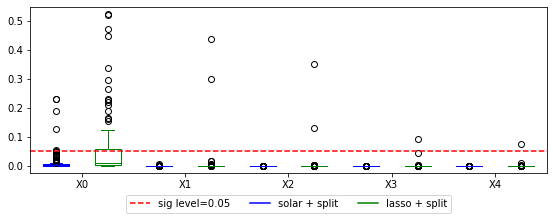

In [13]:
ticks = ['X0', 'X1', 'X2', 'X3', 'X4']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

fig = plt.figure()

bp1 = plt.boxplot(SL_p,  positions=np.arange(0,5)*2-0.5, widths=0.5)
bp2 = plt.boxplot(LA_p,  positions=np.arange(0,5)*2+0.5  , widths=0.5)

plt.axhline(y=0.05, linewidth=1.5, color='r',linestyle='--',label='sig level=0.05')

set_box_color(bp1, 'b')
set_box_color(bp2, 'g')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='b', label='solar + split')
plt.plot([], c='g', label='lasso + split')

plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=5)
plt.xticks(range(0, len(ticks) * 2, 2), ticks)
#plt.ylim(-0.05, 0.36)
#plt.xlim(-1, 9)

plt.tight_layout()
fig.set_size_inches(8,3)
fig.savefig('p_value_compare.pdf', dpi=1200)

In [1]:
!rm -rf example_split.html
!jupyter nbconvert --to html example_split.ipynb 

[NbConvertApp] Converting notebook example_split.ipynb to html
[NbConvertApp] Writing 672126 bytes to example_split.html
